# So, You Have a Diagnostic Test Result

### A kernel exploring the how, what and why of diagnostic testing

*Rob Harrand, 27th Feb 2018*

Datasets used in this kernel,

- [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
- [Indian Liver Patient Records](https://www.kaggle.com/uciml/indian-liver-patient-records)
- [Breast Cancer Wisconsin Diagnostic Dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
- [Health Analytics](https://www.kaggle.com/rajanand/key-indicators-of-annual-health-survey)
- [Health Nutrition and Population Statistics](https://www.kaggle.com/theworldbank/health-nutrition-and-population-statistics)


### Contents

- [Introduction](#Introduction)
- [Medical Testing](#MedicalTesting)
- [Developing a Diagnostic Test](#DevelopingaDiagnosticTest)
- [Test development is done?](#Testdevelopmentisdone?)
- [Confidence Intervals](#ConfidenceIntervals)
- [Enter Rev. Bayes](#EnterRevBayes)
- [The Problem with Sensitivity and Specificity: An Example](#TheproblemwithsensitivityandspecificityAnexample)
- [Context Matters - An Example](#ContextMattersAnExample)
- [Belief Elicitation](#BeliefElicitation)
- [From Prior to Posterior Probabilities](#FromPriortoPosteriorProbabilities)
- [Treatment Thresholds](#TreatmentThresholds)
- [Use In The Real World](#Useintherealworld)
- [Closing Thoughts](#ClosingThoughts)
- [References](#References)

<a id='Introduction'></a>

### Introduction

A number of year ago, a close relative of mine was due the results of a diagnostic test, and they asked me to accompany them to the appointment. I won’t go into the details, but it was a serious condition. I clearly recall the doctor saying, with a solemn voice and a furrowed brow,

***“The results are back. You’ve got a 1 in 64 chance”***

This was followed by a few moments of silence and instant, frantic reflection, before we entered a period of deep gloom that lasted several weeks. Thankfully, a follow-up test with a far higher accuracy was performed, and it came back negative (I think the results claimed odds of something like 1 in 300k). We were all relieved, and over the years this negative test result has shown itself to be correct.

I later became increasingly interested in the theory behind diagnostic tests, and I now realise that our response to that initial test result could have been better. Instead of being frozen with fear, we should have questioned the details of the result and the test, and appreciated that such tests are far from complete, particularly when taken in isolation.


<a id='MedicalTesting'></a>

### Medical Testing

***"Whenever a doctor cannot do good, he must be kept from doing harm"*** - Hippocrates

The act of diagnosing a medical condition is extremely involved$^{[1]}$. When done right, the process is a complex blend of clinical evidence, data, probabilistic rationale and pattern matching, with the consequences of different courses of action kept in mind from a cost and patient care perspective. When done poorly, a range of tests will be performed (often without justification), and conclusions drawn on scant evidence. 

Medical tests are designed to detect, diagnose or monitor disease in a patient, and take on many different formats, including clinical examinations, imaging, biopsies, genetic analysis, and blood tests. Beyond their cost and usability, the most important question for any test is its effectiveness. In other words, how good is a particular test at detecting, diagnosing or monitoring the condition in question?
Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

Notice the denominators. For sensitivity, we have 'true positives', which are of course positives, and 'false negatives', *which are also positives*. So, sensitivity only deals with positive cases, and the logic is the same with specificity for negative cases. The result is that sensitivity is a measure of the probability of getting a positive result out of all the positive cases, and that specificity is a measure of the probability of getting a negative result out of all the negative cases.

Another way of phrasing this is that sensitivity is the probability of getting a positive result, given that you have the disease. Note that in practice, we're interested in the opposite of this, namely the probability of having the disease, given a positive test result (and similarly for not having the disease). For these measures, we use the **positive predictive value (PPV)** and **negative predictive value (NPV)**, respectively,

\begin{align}
PPV = \frac{True\:Positives}{True\:Positives + False\:Positives}
\end{align}

\begin{align}
NPV = \frac{True\:Negatives}{True\:Negatives + False\:Negatives}
\end{align}

Now we have a mix of positives and negatives in the denominators. Despite being arguably more useful, sensitivity and specificity still tend to be the measures of primary focus.

So, let's take a look at some data. Looking at the various Kaggle datasets, the **Pima Indians dataset** looks useful for exploring these ideas,

#### Pima Indians Diabetes Dataset

This dataset relates to the Pima Indian Population, near Phoenix, Arizona. The study is fairly old, starting in 1965, with a range of variables being chosen based upon their significance in other studies, including the number of times the individual had been pregnant, body mass index, and age.

First, let's load the data,

In [1]:
import pandas as pd
diabetes = pd.read_csv('diabetes.csv')

Then have a quick look at the details,

In [2]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Looking at some of the actual data always helps,

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


As you can see, there are a number of 'medical' related pieces of information. Using the lexicon of machine learning, we can frame this data as having one **target variable** ('Outcome'), with the rest being **predictor variables**. The outcome field is a Boolean telling us whether or not the person in question had diabetes or not.

Let's put together a very simple model to predict this outcome based upon some of the predictor variables. Note that I'm not going into the statistics of machine learning here (Kaggle has plenty of examples!). What I'm concerned about is the *interpretation* of the results, rather than optimising the underlying model.

Before diving into creating the model, let's briefly explore the data. First, what is the balance of outcomes?

<Axes: xlabel='Outcome', ylabel='count'>

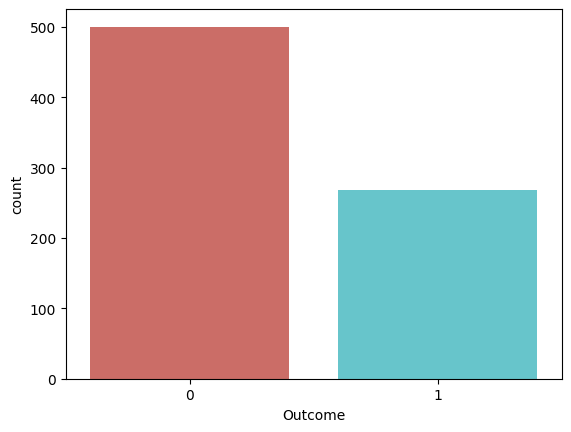

In [4]:
import seaborn as sns
%matplotlib inline

sns.countplot(x='Outcome', data=diabetes, palette='hls')

What about looking at some mean numbers, according to outcome?

In [5]:
diabetes.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


It looks like if you have 4.86 children, you might be in trouble.

Next, I'll load a few bits and pieces, and then check for any missing values,

In [6]:
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

I don't know a lot about diabetes, but I'm pretty sure glucose is important! Let's use a box-plot to see the difference in terms of outcome,

<Axes: xlabel='Outcome', ylabel='Glucose'>

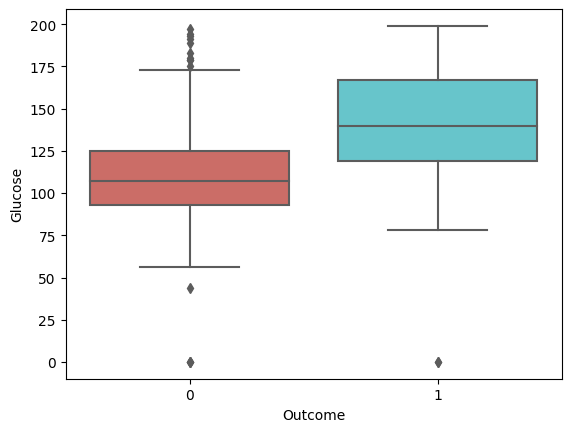

In [8]:
sns.boxplot(x='Outcome', y='Glucose', data=diabetes, palette='hls')

So, glucose is raised, on average, in cases with diabetes. And of course, if we wanted to get into feature selection, the classic **correlation plot** would be useful,

<Axes: >

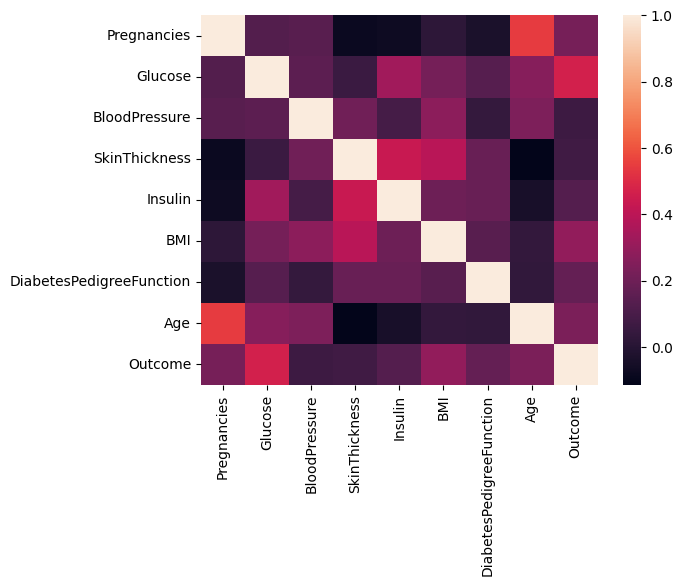

In [9]:
sns.heatmap(diabetes.corr())

OK, let's create a quick, crude model using logistic regression (including splitting into training and test sets, and making predictions),

In [10]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop('Outcome', 1), diabetes['Outcome'], test_size = .3, random_state=25)

C:\Users\neele\AppData\Local\Temp\ipykernel_14804\2957177089.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(diabetes.drop('Outcome', 1), diabetes['Outcome'], test_size = .3, random_state=25)


In [11]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

c:\Users\neele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
y_pred_quant = LogReg.predict_proba(X_test)[:, 1] #Only keep the first column, which is the 'pos' values
y_pred_bin = LogReg.predict(X_test)

[](http://)Now let's create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and work out the sensitivity and specificity,

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[138,  22],
       [ 25,  46]], dtype=int64)

In [14]:
from sklearn.metrics import classification_report

total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.8625
Specificity :  0.647887323943662


Now we encounter the first issue in the world of diagnostic testing, which is that sensitivity and specificity are often treated as static, where-as it of course depends upon the threshold you choose for determining what classes as a positive and what classes as a negative. To check the full range, we use a **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_quant)

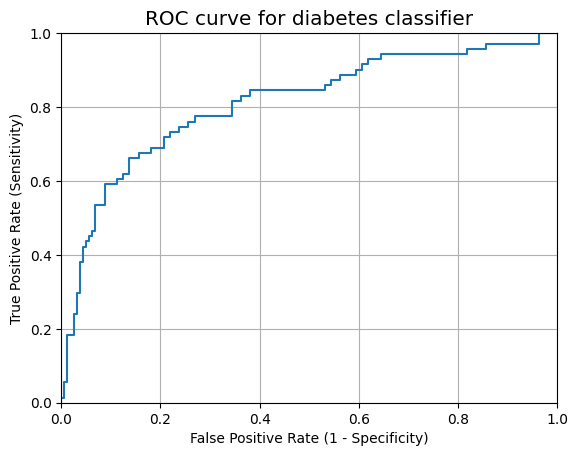

In [25]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the **Area Under the Curve**, or **AUC**. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues$^{[2]}$. As a rule of thumb, an AUC can be classed as follows$^{[3]}$,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [26]:
metrics.auc(fpr, tpr)

0.8108274647887324

Borderline good!

<a id='DevelopingaDiagnosticTest'></a>

### Developing a Diagnostic Test

***"I am dying from the treatment of too many physicians"*** - Alexander the Great

So far, so good. You have a dataset with dozens of predictor variables, you throw them at an algorithm, and you end up with a model to predict new cases. In the medical diagnostic world, however, this isn't how it usually works. The first reason for this is that gathering well characterised cases is hard, because to be able to call one sample 'disease A' and another 'disease B', you have to follow these cases up, perhaps with expensive '[**gold-standard tests**](https://en.wikipedia.org/wiki/Gold_standard_(test)', and/or follow them for many months to see how their condition evolves. Another complication is that people often have more than one thing wrong with them, so seeing that a certain blood-marker is raised in a person with diabetes *might* be due to the diabetes, but it may also be due to some other underlying condition.

What you're typically left with in the case of tests using blood markers, is a relatively low number of cases (a few hundred if you're lucky) with one or more markers measured. These cases may also have some clinical information. Often, a test is based upon just a single marker (take a look at [**acute phase proteins**](https://en.wikipedia.org/wiki/Acute-phase_protein) for instance), with no additional information. No fancy machine learning is employed, it is simply a case of measuring the marker of interest in two cohorts of patients, picking an appropriate cut-off (usually via ROC analysis), and then commercially launching the test. Let's see what this looks like with the **Indian liver patients dataset**,

#### Indian Liver Patients Dataset

To quote verbatim from the [UCI Machine Learning Repository website](https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset), *"This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from north east of Andhra Pradesh, India. Selector is a class label used to divide into groups(liver patient or not). This data set contains 441 male patient records and 142 female patient records. Any patient whose age exceeded 89 is listed as being of age "90"*.

Let's take a look,

In [28]:
liver = pd.read_csv('indian_liver_patient.csv')

In [29]:
liver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [30]:
liver.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


We have all sorts measured here. However, for the benefit of this example, imagine if the only thing we had was 'Total_Bilirubin' and the outcome.

Note that I'm going to change the 'Dataset' column name to 'Outcome', in order to be consistent with the analysis above. I'm also going to change the 1s and 2s in this column to 1s and 0s (initial state is that 1 = liver disease, 2 = no liver disease),

In [31]:
liver.rename(columns = {'Dataset':'Outcome'}, inplace = True)
liver['Outcome'].replace(to_replace=2, value=0, inplace=True)

Check the summary by outcome,

In [32]:
liver.groupby('Outcome').mean()

C:\Users\neele\AppData\Local\Temp\ipykernel_14804\1607557819.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  liver.groupby('Outcome').mean()


,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
Outcome,,,,,,,,,
0,41.239521,1.142515,0.396407,219.754491,33.652695,40.688623,6.543114,3.344311,1.029576
1,46.153846,4.164423,1.923558,319.007212,99.605769,137.699519,6.459135,3.060577,0.914179


Let's just grab the two columns we're interested in,

In [33]:
liver_sub = liver.iloc[:,[2,10]]

In [34]:
liver_sub.head()

,Total_Bilirubin,Outcome
0,0.7,1
1,10.9,1
2,7.3,1
3,1.0,1
4,3.9,1


Let's sanity-check whether or not we think there is any discriminatory power in this marker with a box-plot,

<Axes: xlabel='Outcome', ylabel='Total_Bilirubin'>

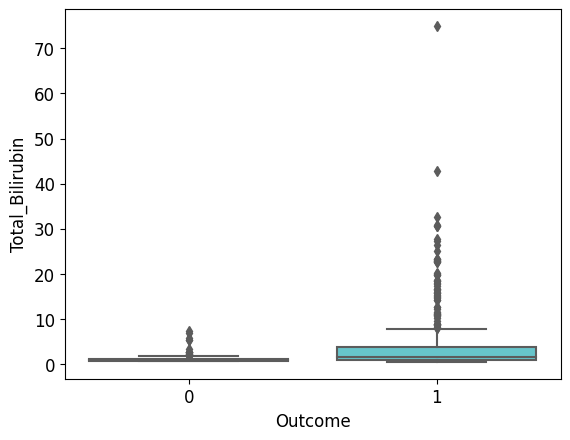

In [35]:
sns.boxplot(x='Outcome', y='Total_Bilirubin', data=liver_sub, palette='hls')

It looks like Total Bilirubin is raised in liver condition cases, especially in the case of the outliers. Let's also check without the outliers,

<Axes: xlabel='Outcome', ylabel='Total_Bilirubin'>

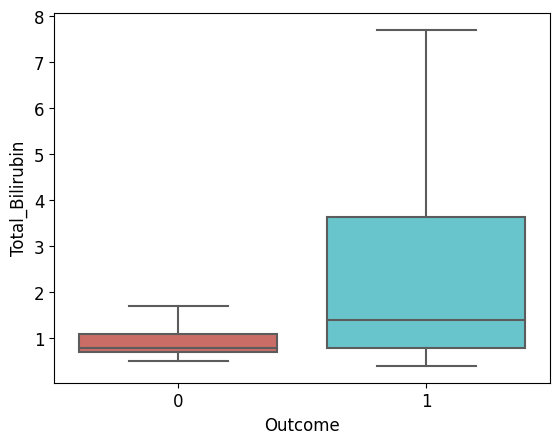

In [36]:
sns.boxplot(x='Outcome', y='Total_Bilirubin', data=liver_sub, palette='hls', showfliers=False)

We could also check things with a histogram,

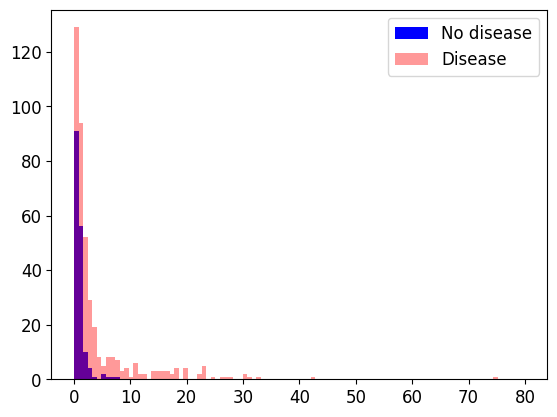

In [37]:
bins = np.linspace(0, 80, 100)

plt.hist(liver_sub['Total_Bilirubin'][liver_sub['Outcome'] == 0], bins, label='No disease',fc=(0, 0, 1, 1))
plt.hist(liver_sub['Total_Bilirubin'][liver_sub['Outcome'] == 1], bins, label='Disease',fc=(1, 0, 0, 0.4))
plt.legend(loc='upper right')
plt.show()

OK, there is definitely some difference here. This makes physiological sense, as bilirubin is known to be a by-product of the breakdown of red blood cells, which should be efficiently dealt with by the liver. So raised levels can indicate that the liver is not functioning correctly$^{[4]}$. That said, there is overlap, so we shouldn't be surprised if the separation of the two groups with some cut-off value and the consequent sensitivity and specificity are fairly poor.

Let's keep going with this marker and create a ROC plot from scratch. The following code evaluates the sensitivity and specificity at 100 different thresholds across the range of the Total_Bilirubin, then plots the results,

In [38]:
tb = liver_sub['Total_Bilirubin']
pred = np.zeros(tb.size)
tb_min = np.min(tb)
tb_max = np.max(tb)
tb_range = tb_max - tb_min
thresh_inc_size = 100
tb_inc = tb_range / thresh_inc_size
no_thresholds = tb_range / tb_inc.size
no_thresholds = np.ceil(no_thresholds)
no_thresholds = no_thresholds.astype(int)
sens = pd.Series(np.zeros(no_thresholds))
spec = pd.Series(np.zeros(no_thresholds))

tb_cutoff = tb_min
i=0
y=0

In [39]:
while (y <= thresh_inc_size):
    while (i<tb.size):
        if (tb[i] >= tb_cutoff):
            pred[i] = 1
        else:
            pred[i] = 0
        i=i+1
    confusion_matrix = metrics.confusion_matrix(liver_sub['Outcome'], pred)
    sens[y] = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
    spec[y] = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
    i=0    
    y=y+1
    tb_cutoff = tb_cutoff + tb_inc

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

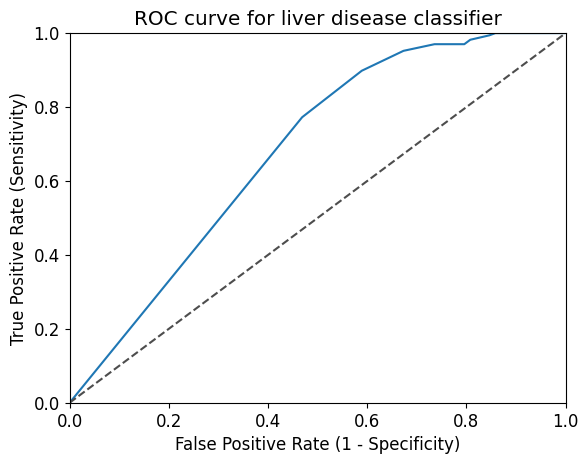

In [40]:
fig, ax = plt.subplots()
ax.plot(1-spec, sens)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for liver disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

To reiterate, this ROC plot has *not* been generated by varying the probability between 0 and 1 like machine-learning applications. Now, the threshold that is being varied is the blood marker value, between the minimum and maximum values.

There are various ways to pick the most suitable cut-off point. Some use the **Youden index**$^{[5]}$
, which is a way to balance sensitivity and specificity by selecting the point on the ROC plot that maximizes the difference between sensitivity and 1-specificity. However, one thing to keep in mind here is that a false positive may not perfectly equal a false negative in terms of cost. For example, in medical testing, a false positive may lead to the administration of drugs that aren't needed, resulting in side-effects and financial costs, but a false negative could lead to death. Arguably not the same!

Alternatively, a high sensitivity may be selected (at the expense of specificity) for a **rule-out** test, or a high specificity may be selected (at the expense of sensitivity) for a **rule-in** test.

From the plot above, you can see that at a moderate sensitivity of 0.8, you're getting a poor specificity of ~0.5. Better than a coin-toss (the dotted line), but not amazing.

There are a number of good papers on using ROC plots with diagnostic tests$^{[6-8]}$

Next, let's take a look at a different Kaggle dataset,

#### Breast Cancer Wisconsin (Diagnostic) Data Set

This dataset contains information on cell shape for individuals with benign or malignant tumours. According to the UCI website, *"Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image"*

Let's load the data and have a look,

In [41]:
bcancer = pd.read_csv('breastcancer.csv')

In [42]:
bcancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Lots of variables here. Let's see some data,

In [43]:
bcancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


And a look at the different features by the two classes (benign and malignant),

In [44]:
bcancer.groupby('diagnosis').mean()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,2.654382e+07,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,...,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,NaN
M,3.681805e+07,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,...,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,NaN


It looks like there are some differences here. Let's grab a few and create a model and a ROC plot. Again, I'm not trying to revolutionise cancer diagnostics, but it would be good to get a new example for some of the bits that follow,

In [45]:
bcancer_sub = bcancer.iloc[:,[1,5,8]] #These features were found to be useful in other Kaggle kernels

In [46]:
bcancer_sub.head()

,diagnosis,area_mean,concavity_mean
0,M,1001.0,0.3001
1,M,1326.0,0.0869
2,M,1203.0,0.1974
3,M,386.1,0.2414
4,M,1297.0,0.1980


In [47]:
X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3, random_state=25)

C:\Users\neele\AppData\Local\Temp\ipykernel_14804\72970997.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3, random_state=25)


In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(seed=100)
dtree = DecisionTreeClassifier(criterion = "gini", random_state = 10, max_depth=3, min_samples_leaf=3)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=10)

In [50]:
y_pred_quant = dtree.predict_proba(X_test)[:, 1] #Only keep the first column, which is the 'pos' values
y_pred_bin = dtree.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[99, 14],
       [ 4, 54]], dtype=int64)

Sensitivity :  0.8761061946902655
Specificity :  0.9310344827586207


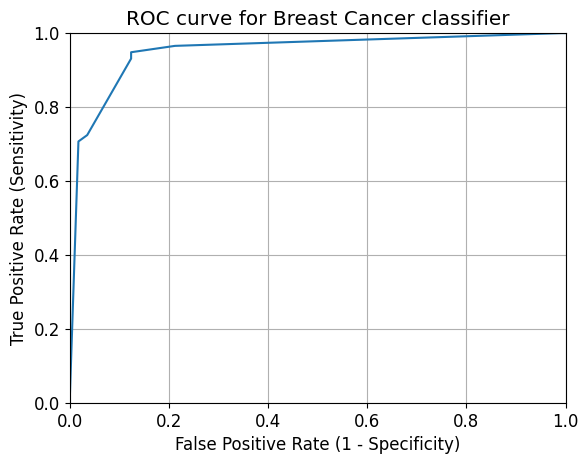

In [51]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_quant, pos_label='M')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Breast Cancer classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
#plt.axhline(y=sensitivity, color='r')
#plt.axvline(x=1-specificity, color='r')

Let's check the AUC,

In [52]:
metrics.auc(fpr, tpr)

0.9510222764723834

Not bad.

<a id='Testdevelopmentisdone?'></a>

### Test development is done?

***"Either do not attempt at all, or go through with it"*** - Ovid

In my experience, this is about as far as many diagnostic tests get. Some don't even go as far as creating a ROC plot, some are only based on a single predictor variable, and some only quote sensitivity *or* specificity. Leaving those concerns aside, the situation that this leaves is that often there is a fixation on these two numbers, and it has effectively led to a battle within the literature of *"my sens and spec are better than your sens and spec"*. 

In reality, a number of fundamental problems exist with this approach. These include,

1. Sensitivity and specificity are measurements of how the test performed on a past cohort. They are, therefore, general measurements of the test performance against a sample, and not specific for the individual patient in question
2. These metrics are only useful if the chosen test patients are relevant to the test. A common failing here is to include healthy patients when the test is only ever to be used on diseased individuals$^{[9, 10]}$. In other words, these metrics are only useful if the patient in question is from a population that matches that that the test was developed upon (in terms of both disease type and disease prevalence)$^{[9, 10]}$
3. Sensitivity and specificity can be altered based upon the threshold used. The full range of possible options should be given in the form of a Receiver operating characteristic (ROC) curve, but often it is not, focussing instead on a single, often arbitrary point$^{[11]}$
4. Confidence intervals are rarely focussed upon
5. Ruling out or ruling in, with a focus only on sensitivity or specificity fails to take into account a test’s true predictive ability. This may mean that the results of the test are not ruling out or ruling in to the degree expected$^{[12,13]}$

The solution to items 2 – 5 on this list is simply to do better science. Indeed, papers have been published with the sole aim to improve the design and consequent reporting of diagnostic tests, including **'Standards for
Reporting Diagnostic accuracy studies' (STARD)** $^{[9, 10]}$.

Another factors are **cost**, **risk** and **urgency**. What if you have two tests with comparable sensitivity and specificity, but the one that is slightly higher costs twice as much as the other, takes twice as long and comes with potential side-effects? Now the improved performance may be deemed insignificant.

This list also alludes to an elephant-sized issue with diagnostic test development, that of **bias**[14]. To elaborate, sources of bias include the following,

- **Selection bias** - Eligible cases aren't selected randomly
- **Spectrum bias** - Cases don't correctly represent the target condition or severity of condition
- **Misclassification bias** - When the cases aren't classed correctly (i.e. 'with disease' and 'without disease')

Etc.

Before moving on, I want to highlight item 4 in the above list (confidence intervals), as this is one that we can demonstrate with data.

<a id='ConfidenceIntervals'></a>

### Confidence Intervals

***“I couldn't claim that I was smarter than sixty-five other guys--but the average of sixty-five other guys, certainly!”*** - Richard Feynman

Flicking through any statistics book will reveal a seemingly limitless array of theorems, equations, models, tools and techniques. Understanding the details of them all is extremely difficult, not-to-mention arguabley inefficient given the number of guides available that point you in the direction of which bits of stats you need for a given problem or data type. 
That said, having a good understanding of some core principles can help enormously, both in the understanding of your own results, and in order to critique the findings of others. One of these, I would argue, is the [**central limit theorem**](https://en.wikipedia.org/wiki/Central_limit_theorem). The consequences of this theorem are wide-ranging, but the one of interest here is that of [**confidence intervals**](https://en.wikipedia.org/wiki/Confidence_interval). If you're not sure what they are, I encourage you to follow the previous links to find out more.

Here, the consequence of confidence intervals are that for metrics such as sensitivity and specificity, what we have in reality are *estimates* of values, due to the fact that we only have a sample of cases from a wider population. The consequence of this is that if people are promoting a test with high sensitivity as a rule-out test (or high specificity for rule-in), if the lower value from the confidence limits is significantly lower, then your test may be no-where near good enough for this purpose. 

Let's see an example. From the quick model above, we have a specificity of ~0.93. Some may claim that that's sufficient to rule-in a disease (typically you'd want it higher than that, but let's assume 0.93 is okay for our purposes). Now let's look at the confidence interval for the sensitivity and specificity. To do this, we'll use a technique called [**bootstrapping**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), which samples many times from the training data, creates a new model for each one, and generates a sensitivity and specificity for each model,

C:\Users\neele\AppData\Local\Temp\ipykernel_14804\870487670.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3)
C:\Users\neele\AppData\Local\Temp\ipykernel_14804\870487670.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3)
C:\Users\neele\AppData\Local\Temp\ipykernel_14804\870487670.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3)
C:\Users\neel

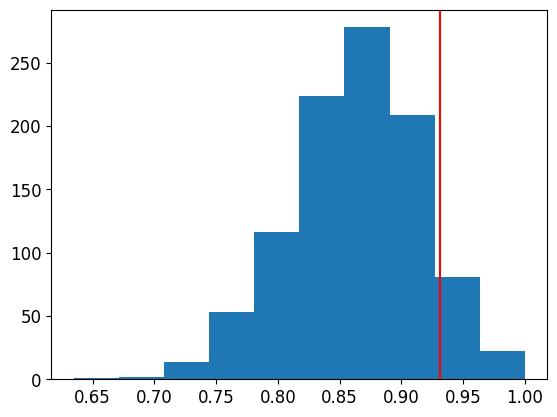

95.0 confidence interval 75.0% and 95.5%


In [53]:
from sklearn.utils import resample

specificity_orig = specificity

# configure bootstrap
n_iterations = 1000
n_size = int(len(bcancer_sub) * 0.25)

# run bootstrap
sens = list()
spec = list()

for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test = train_test_split(bcancer_sub.drop('diagnosis', 1), bcancer_sub['diagnosis'], test_size = .3)
    # fit model
    dtree = DecisionTreeClassifier(criterion = "gini", random_state = 10, max_depth=3, min_samples_leaf=3)
    dtree.fit(X_train, y_train)
    # evaluate model
    y_pred_quant = dtree.predict_proba(X_test)[:, 1] #Only keep the first column, which is the 'pos' values
    y_pred_bin = dtree.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred_bin)
    sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
    specificity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
    sens.append(sensitivity)
    spec.append(specificity)
    
# plot scores
plt.hist(spec)
plt.axvline(x=specificity_orig, color='r')
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(spec, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(spec, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

*Thanks to [Machine Learning Mastery](https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/) for help with the bootstrapping*

So, we have a significantly lower specificity at a 95% confidence level. No-where near good enough to rule-in. This is another aspect of diagnostic testing that is often overlooked.

Returning to the list of diagnostic test problems, item 1 on the list is particularly fundamental, and requires a different approach to diagnostic testing in general. The way to do this is not novel, and has been in the literature for a number of decades. However, its understanding and application are not straightforward and these facts have hindered widespread use. Let's take a look...

<a id='EnterRevBayes'></a>

### Enter Rev. Bayes

***"The world is full of obvious things which nobody by any chance ever observes."*** - Sherlock Holmes Quote (The Hound of the Baskervilles)

Bayesian statistics is a topic often seen in machine learning circles. However, in my experience, the area often used is that of using [**Markov Chain Monte Carlo (MCMC)**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to ascertain the details of one or more posterior distributions. The fundamental idea of [**Bayes Rule**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is much simpler, and is simply the idea of updating prior beliefs based upon new information. In the diagnostic world, this simple idea can be incredibly powerful$^{[15]}$, but unfortunately, often ignored.

To show what I mean, in a paper by Reid et al$^{[16]}$, 300 physicians were surveyed regarding their use of test accuracy metrics, and it was found that just 3% used the recommended formal Bayesian calculations (with a large number citing a lack of understanding of sensitivity, specificity, ROC curves and likelihood ratios for their lack of use). Another paper by Whiting et al$^{[17]}$ also concluded that *"Commonly used measures of test accuracy are poorly understood by health professionals"*.

The prevailing type of statistics and that used in all traditional applications is known as [**frequentist**](https://en.wikipedia.org/wiki/Frequentist_inference) statistics. This approach assigns probabilities based upon the frequency of events occurring. In contrast, in the [**Bayesian**](https://en.wikipedia.org/wiki/Bayesian_inference) mindset, probabilities are related to our current level of knowledge about an event. This latter approach allows the introduction of something called a [**prior**](https://en.wikipedia.org/wiki/Prior_probability) (explained in more detail later), which is a probability assigned *before* data is collected on an event. This prior is combined with new evidence to give a **posterior** probability.

It represents, therefore, (as the name suggested) a prior belief. To the Bayesian, this is Bayesian statistics’ biggest strength, as it allows the full weight of pre-existing evidence and domain knowledge to be brought to bear$^{[18]}$. To the frequentist, this is Bayesian statistics’ biggest weakness, as it introduces a subjective element into what is an objective branch of science. 

This prior can be deduced in many ways. At the most subjective, it is simply a gut-feeling for the probability of something (for example, the probability of disease based upon experience and training). Less subjective is a local **prevalence**, for example, the prevalence of a certain disease in a certain clinic. The most rigorous way of determining a prior is through a process known as **elicitation**. This is where a prior probability is determined from a careful examination of the situation. For example, this may be via a series of well-designed questions regarding the state of an individual patient.

<a id='TheproblemwithsensitivityandspecificityAnexample'></a>

### The Problem with Sensitivity and Specificity: An Example

Sensitivity is the probability of getting a positive result given the presence of the disease. It is test-specific and says nothing about the individual patient. Instead, what the patient cares about is the inverse; the probability of having the disease given a positive result. This can be computed using [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem), which is,

\begin{align}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
\end{align}

This reads as ‘the probability of A given B is equal to the probability of B given A, multiplied by the probability of A, divided by the probability of B’. Notice that it's giving us P(A|B) using P(B|A), which is what the PPV gives us compared to sensitivity, as mentioned previously. PPV can be derived from Bayes rule, but doing it that way *assumes that the patient in question has a prior probability approximately equal to the prevalence in the reference group*. If that's not the case, then you need to use Bayes rule with your alternative prior, as shown below.

In the equation above, P(A) is the probability of having the disease and P(B) is the probability of getting a positive result. What are these values? P(A) is the prior (mentioned above). Local disease prevalence is often used for P(A) and will be used in the example below. P(B) is the combination of all the ways a positive result could be obtained, i.e. the patient could have the disease and get a positive result or the patient could not have the disease and get a positive result. Specifically (recalling that conditional probabilities are obtained by multiplication),

\begin{align}
P(+ve) = P(disease) * P(+ve\:|\:disease) + P(no\:disease) * P(+ve\:|\:no\:disease)
\end{align}

Looking back at the diabetes model results from earlier, we had a sensitivity of ~87% and a specificity of ~61%. We can now obtain the probability of disease, given the disease prevalence. Let’s say that you're using this test in a different population than the test was evaluated in (often the case in the real world), and that we have a prevalence of 5%. We have,

\begin{align}
P(disease\:|\:+ve) = P(+ve\:|\:disease)\:*\:\frac{P(disease)}{P(+ve)}
\end{align}

\begin{align}
P(disease\:|\:+ve) = P(+ve\:|\:disease)\:*\:\frac{P(disease)}{P(disease)\:*\:P(+ve\:|\:disease)\:+\:no\:disease\:*\:P(+ve\:|\:no\:disease)}
\end{align}

\begin{align}
P(disease\:|\:+ve) = \frac{0.87\:*\:0.05}{(0.05 * 0.87) + (0.95 * 0.39)}
\end{align}

(Note that the value of 0.39 comes from 1 - specificity)

\begin{align}
P(disease\:|\:+ve) = 0.105
\end{align}

So, the probability of a patient having diabetes with a positive result of the test, with a disease prevalence of 5% and a test of sensitivity of 87% and specificity of 61% is **10%**.

<a id='ContextMattersAnExample'></a>

### Context Matters - An Example

These sorts of calculations are often not well understood or in the forefront of clinician's minds when diagnosing disease. In fact, there are some quite scary studies demonstrating the serious levels of error in posterior probability estimates when health professionals are presented with tests with very high levels of sensitivity and specificity, plus the widespread practice of ignoring formal Bayesian calculations$^{[19]}$. This is serious stuff, because without taking into account the context of a diagnostic test result, either properly or at all, you're left with a single piece of evidence that is impossible to interpret. 

For example, imagine you have a diagnostic test for Ebola with reasonably high levels of sensitivity and specificity, and you run it on someone. You get a **positive** result. Does the person have Ebola?

What if you'd run the test in Sierra Leone in 2015. The context suggests you've got a true positive. What about if the test had been run on someone living in a remote rural location in the highlands of Scotland? Now it's looking like a false positive. But wait a minute, it turns out that this person was just back from a voluntary medical placement in Sierra Leone. Back to true positive. Next you discover they had an experimental but highly effective Ebola vaccine last year. Now what?

Or, take a more extreme example. Home pregnancy tests aren't perfect. If you tested them on thousands of men, you may get a few false-positives (I believe there is some evidence that the hormone that the test looks for, [**beta human chorionic gonadotropin (hCG)**](https://en.wikipedia.org/wiki/Human_chorionic_gonadotropin), is raised in some types of cancer$^{[20]}$). But if your aim is to answer the question 'is this person pregnant?', a positive result from the test would be dragged down to zero for a man, given the wider biologic context (setting aside [Arnold Schwarzenegger films](https://en.wikipedia.org/wiki/Junior_(1994_film)), *because the prior is zero*.

The test characteristics haven’t changed, but the context *frames* an imperfect result. How an individual does this is critical during the medical decision-making process, and in formal Bayesian contexts, this often involves elicitation.

<a id='BeliefElicitation'></a>

### Belief Elicitation

Elicitation is ...*"the process of translating someone's judgement about some uncertain quantities into something useful for a model"*$^{[21]}$ and that *"This will typically be a probability distribution"*.

In other words, it's translating from a doctor saying *"I'm not sure if that patient has disease X, but I'm pretty confident that one does"* to *"Patient A has a prior probability of 20% and patient B has a prior probability of 90%"*. Now, the danger here is that ten different doctors give you ten different probabilities, due to differences in knowledge, experience and personal biases. For example, one study from 1986 assessing the prior beliefs of 104 clinicians (elicited based upon reviewing patient case summaries) vs actual patient outcomes found huge variations in estimates (ranges of >90%), concluding that the subjective beliefs were largely inaccurate$^{[22]}$. There is also research showing a whole host of reasons why such subjectivity can falter, including,

- ***Availability heuristic*** *(clinicians judge the likelihood of a particular diagnosis by how easily examples spring to mind)*
- ***Anchoring heuristic*** *(physicians stick with initial impressions)*
- ***Framing effects*** *(people make different decisions based on how information is presented)*
- ***Blind obedience*** *(trainees stop thinking when confronted with authority)*
- ***Premature closure*** *(when several possible options are not pursued)”* $^{[1]}$

Since the time of the 1986 paper, there have been efforts to improve the elicitation methodology. In one recent review of the subject$^{[23]}$, they state that *"'Prior belief is often a combination of fact-based knowledge with subjective impressions based on clinical experience"* and that to answer the criticisms of introducing a subjective element, that *"belief-elicitation methods should be valid, reliable, responsive to change, and feasible"*. They go on to warn that *"Threats to the reliability of an elicitation procedure include lack of understanding of the elicitation procedure, carelessness, lack of interest, and fatigue"*.

Setting aside the subjective elements of prior elicitation, one simpler and objective method is to use the prevalence on the disease in question (as mentioned previously). This, however, comes with its own problems. How do we define 'prevalence'? Is it the national prevalence? County prevalence? Prevalence of an individual hospital? What about age, sex and clinical signs? Is it right to use the same prevalence for a 10-year-old and an 80-year-old? Probably not. In one review of the ways in which disease rates in populations can be quantified$^{[24]}$, they discuss the **point-prevalence** (a snap-shop of disease rates now), and **period-prevalence** (the overall prevalence over, say, a 12 month period), going on to discuss **'crude' prevalence** (which is the gross, population level estimate) and **'specific'** estimates (breaking down by age and sex, for example). An example of this can be found in a 2017 study$^{[25]}$ of crude and specific prevalence of diabetes, where they found that the crude prevalence was 1.13 per 1000, but much higher at 3.94 for those aged 70-79.

<a id='FromPriortoPosteriorProbabilities'></a>

### From Prior to Posterior Probabilities

So, how do you go from a prior probability to a posterior one, via a diagnostic test? The answer is to use something called [**likelihood ratios**](https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing), and these have the key feature that they incorporate both the sensitivity and the specificity. Indeed, a major criticism of diagnostic testing is when people try to rule-in or rule-out diseases using only a single metric.

For example, it is often seen in diagnostic literature that a high sensitivity test is very useful for ruling-out a disease. This is because a high-sensitivity test 'wants' to give a positive answer, meaning it will do so with only a small amount of evidence. Therefore, if you get a negative result with such a test, the logic is that the evidence for a positive result is extremely small. The same (but reverse) logic holds for ruling-in a disease.

However, what if your super-sensitive test has a very poor specificity? Say, a sensitivity of 98% and a specificity of 10%. It could be argued at this point that you're not that much further from just calling every case you see a positive (which would give you a sensitivity of 100% and specificity of 0%). In other words, your test's overall predictive ability is poor. A number of articles/papers are available that explain the consequences of such issues$^{[26,27]}$

Likelihood ratios are calculated as follows,

\begin{align}
Positive\:Likelihood\:Ratio = \frac{Sensitivity}{(1-Specificity)}
\end{align}

\begin{align}
Negative\:Likelihood\:Ratio = \frac{1-Sensitivity}{(Specificity)}
\end{align}

To go from a prior to a posterior using these ratios, people have historically used something called a [**Fagan Nonogram**](http://www.pmean.com/definitions/fagan.htm). This is a graphical tool that allows the user to draw a line from the prior probability through a likelihood ratio, in order to reach a posterior probability. However, given a computer, it's much easier to just computer the result. For this, we use the following equations,

\begin{align}
Prior\:odds = \frac{prior\:probability}{(1-prior\:probability)}
\end{align}

\begin{align}
Posterior\:odds = Prior\:odds * Likelihood\:Ratio
\end{align}

\begin{align}
Posterior\:probability = \frac{Posterior\:odds}{(Posterior\:odds + 1)}
\end{align}


Let's put that into a function,

In [ ]:
def diagnostic_posterior(prior,sens,spec):
    lr_pos = sens / (1 - spec) #Positive likelihood ratio
    lr_neg = (1 - sens) / spec #Negative likelihood ratio
    
    pre_odds = prior / (1-prior) #Prior odds
    post_odds_pos = pre_odds * lr_pos #Positive posterior odds
    post_odds_neg = pre_odds * lr_neg #Negative posterior odds
    post_pos = post_odds_pos / (1+post_odds_pos) #Positive posterior probability
    post_neg = post_odds_neg / (1+post_odds_neg) #Negative posterior probability
    
    return(post_pos, post_neg)

Note that you can get a sense of how much your likelihood ratios will affect the posterior probability from their values. For example, a likelihood ratio of 1 won't affect it at all, a likelihood ratio of 0.1 will lead to a large decrease, and a likelihood ratio of 10 will lead to a large increase. In the breast cancer data above, a quick model gave us a sensitivity of ~0.88 and a specificity of ~0.93. Let's see what the likelihood ratios would be,

In [ ]:
lr_pos = 0.88 / (1 - 0.93) #Positive likelihood ratio
lr_neg = (1 - 0.88) / 0.93 #Negative likelihood ratio
print("The positive and negative likelihood ratios are %s, and %s, respectively" % (round(lr_pos,2), round(lr_neg,2)))

We can now use the above function get posterior probabilities, which we'll do with a new dataset below.

Before we do, a quick warning. Often, diagnostic tests are done sequentially (using the posterior probability of one test as the prior probability of the next). If the first test in a chain of tests is a quick, cheap test used for **triaging**, and the second test is a more accurate version, that's fine. For example, you use a high sensitivity test to quickly detect as many positives (including some false positives) from a group of patients, and then you can perform a potentially more expensive test on those flagged.

If, however, you wish to update your posterior probability through-out a chain of tests, you need to be very careful that the tests are **conditionally independent**. For example, let's say you assign a prior probability of a patient having a certain disease at 10%. You then run a test that comes back positive, and you end up with a posterior of 50%. It would clearly be crazy to rerun the test, get another positive, and update your probability again, but this is exactly what you're doing if a second test is effectively mimicking the first.

With all of this in mind, let's generate some posterior probabilities. Looking through the Kaggle datasets led me to a couple that could illuminate this point. These are the 'Health Analytics' and the 'Health Nutrition and Population Statistics' datasets.

#### Health Analytics Dataset

This data stems from an annual health survey established in 2005 by the National Commission of Population, India, with the goal of providing data to improve district-level planning.

Let's take a look,

In [ ]:
health = pd.read_csv('../input/key-indicators-of-annual-health-survey/Key_indicator_statewise.csv')

In [ ]:
health.info()

Let's use the data relating to acute respiratory infections,

In [ ]:
health_sub = health.loc[:,['State_Name', 'UU_Children_Suffering_From_Acute_Respiratory_Infection_Total', 'UU_Children_Suffering_From_Acute_Respiratory_Infection_Rural', 'UU_Children_Suffering_From_Acute_Respiratory_Infection_Urban']]

In [ ]:
health_sub

So, the context here is that if a child was taken to a clinician with breathing difficulties, an acute respiratory infection might be suspected. Let's say a test is available for such a condition with a particular sensitivity and specificity. We could use the data here as a prior probability, and what's interesting is that we have specific values for different states and different environments. For example, take a look at the minimum value in the table,

In [ ]:
health_sub.loc[health_sub['UU_Children_Suffering_From_Acute_Respiratory_Infection_Total'].idxmin()]

And the maximum,

In [ ]:
health_sub.loc[health_sub['UU_Children_Suffering_From_Acute_Respiratory_Infection_Total'].idxmax()]

So, it could be argued that a child with suspected acute respiratory infection in Bihar, living in a rural area has a prior of 27.9%, and a child from Uttarakhand also living in a rural area has a prior of 10.96%. These differences would matter!

Let's use a different dataset to perform some calculations,

#### Health Nutrition and Population Statistics Dataset

Collated by the WorldBank, this dataset provides information on a large range of health-related topics. The quote the [official website](https://datacatalog.worldbank.org/dataset/health-nutrition-and-population-statistics), *"HealthStats provides key health, nutrition and population statistics gathered from a variety of international sources. Themes include population dynamics, nutrition, reproductive health, health financing, medical resources and usage, immunization, infectious diseases, HIV/AIDS, DALY, population projections and lending. HealthStats also includes health, nutrition and population statistics by wealth quintiles"*

In [ ]:
global_health = pd.read_csv('../input/health-nutrition-and-population-statistics/data.csv')

In [ ]:
global_health.head()

Let's use data on HIV prevalence,

In [ ]:
global_health_sub = global_health[global_health['Indicator Name'].str.contains('Prevalence of HIV')]

In [ ]:
global_health_sub = global_health_sub.loc[:,('Country Name', 'Indicator Name', '2005')]

In [ ]:
global_health_sub = global_health_sub.dropna(subset = ['2005'])

In [ ]:
global_health_sub.sort_values(['2005']).head()

In [ ]:
global_health_sub.sort_values(['2005']).tail()

The data for different countries,

In [ ]:
global_health_sub[global_health_sub['Country Name'] == 'Swaziland']

In [ ]:
global_health_sub[global_health_sub['Country Name'] == 'Belarus']

So, let's say we have a quick, cheap, [point-of-care](https://en.wikipedia.org/wiki/Point-of-care_testing) HIV test that works on a single drop of blood and gives a YES/NO answer in 10 minutes (this would probably be a [lateral flow device](https://en.wikipedia.org/wiki/Lateral_flow_test), like with a home pregnancy test). The test has a sensitivity and specificity of 99%, and you run the test on four different people,

- A 20 year old man from Swaziland
- A 20 year old woman from Swaziland
- A 20 year old man from Belarus
- A 20 year old woman from Belarus

All four test results are 'YES' (or positive for HIV). What is the probability, based upon the data we have, that they've got HIV? Let's take a look,

In [ ]:
print("A 20 year old man from Swaziland probability is {:0.2f}".format(diagnostic_posterior(0.181,0.99,0.99)[0]))
print("A 20 year old woman from Swaziland probability is {:0.2f}".format(diagnostic_posterior(0.067,0.99,0.99)[0]))
print("A 20 year old man from Belarus probability is {:0.2f}".format(diagnostic_posterior(0.001,0.99,0.99)[0]))
print("A 20 year old woman from Belarus probability is {:0.2f}".format(diagnostic_posterior(0.001,0.99,0.99)[0]))

So, the exact same test giving the exact same result could mean the person has a **9%** or **96%** chance of having HIV. **Context matters!**

Let's generate the posterior probability for this imaginary test at all prevalences,

In [ ]:
post = list()
prev_options = np.arange(0.0, 1.0, 0.01)

for i in prev_options:
    post_temp = diagnostic_posterior(i,0.99,0.99)[0]
    post.append(post_temp)

Then plot the results, along with the two prevalences highlighted above,

In [ ]:
fig, ax = plt.subplots()
ax.plot(prev_options, post)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('Prevalence vs Posterior Probability (sens/spec = 0.99)')
plt.xlabel('Prevalence')
plt.ylabel('Posterior Probability')
plt.axvline(x=0.181, color='r')
plt.axvline(x=0.001, color='r')

As you can see, at such high sensitivity and specificity, the posterior probability jumps very quickly, meaning that you only need a small prior probability (disease prevalence here) for the test to give a high probability. If the sensitivity and specificity were lower (say, both 0.80), the rise would be more gradual,

In [ ]:
post = list()
prev_options = np.arange(0.0, 1.0, 0.01)

for i in prev_options:
    post_temp = diagnostic_posterior(i,0.80,0.80)[0]
    post.append(post_temp)
    
fig, ax = plt.subplots()
ax.plot(prev_options, post)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('Prevalence vs Posterior Probability (sens/spec = 0.80)')
plt.xlabel('Prevalence')
plt.ylabel('Posterior Probability')

<a id='TreatmentThresholds'></a>

### Treatment Thresholds

***"The art of medicine consists in amusing the patient while nature cures the disease"*** - Voltaire

There is one more consequence of all this, which, if used more by medical professionals could save quite a lot of money. The idea is that of treatment thresholds, which are informal levels above which the clinician would take a certain course of action$^{[28]}$. For example, let's say that a clinician is about to run a diagnostic test for a certain disease, and it costs £50. The sensitivity of the test is 92% and the specificity is 85%, and the threshold for treatment, i.e. the posterior probability above which a certain drug will be prescribed, is 90%. Now let's say the prior probability is estimated to be just 1%. Before the test is run, let's see what the posterior probability will be *if we get a positive result*,

In [ ]:
diagnostic_posterior(0.01,0.92,0.85)[0]

Just under 6%. No-where near the informal 90% that the clinician had in mind for starting the course of treatment. Therefore, *there is absolutely no point running the test*, as it's result, whether negative or positive, *will not change the course of action*. How many tests are run globally, every day, that fit this description? I dread to think! The takeaway here is that diagnostic tests should only be used when their outcome could alter the **management of the patient**.

<a id='Useintherealworld'></a>

### Use in the Real World

The application of Bayesian statistics to diagnostic testing is widespread in the literature. Almost all have a common theme; They begin by criticising the current, common application of diagnostic test results, and then propose using Bayesian statistics instead$^{[29-40]}$. All the arguments and explanations above can be found repeated in these papers.

The elicitation of prior probabilities and their effectiveness is a large area of research$^{[41-47]}$, demonstrating that the establishment of pre-test probabilities can potentially involve immense amounts of work. It should be noted, however, that often this work is focussed upon establishing **prior distributions** (i.e. not just single values) for every term in a complex statistical model. These priors are commonly described using [beta distributions](https://en.wikipedia.org/wiki/Beta_distribution). The posterior probabilities are then determined using advanced computational techniques such as MCMC. This is a level of detail and technicality beyond what is being proposed here.

A number of papers exist that employ Bayesian techniques in the manner outlined above. For example, in a paper by Cochon et al$^{[48]}$, the diagnostic value of lactate, [procalcitonin](https://en.wikipedia.org/wiki/Procalcitonin) (PCT) and [C-reactive protein](https://en.wikipedia.org/wiki/C-reactive_protein) (CRP) are assessed for the diagnosis of [sepsis](https://en.wikipedia.org/wiki/Sepsis). However, rather than taking the results of these tests in isolation, the results are combined with prior probabilities, along with each test’s positive and negative likelihood ratios. Interestingly, rather than using a subjective prior, the patients in the study were stratified into three groups (low risk, medium risk and high risk) using the **Mortality in Emergency Department (MEDS) risk score** $^{[49,50]}$. This is a system based upon a series of risk factors, including age, platelet count and mental state. Their conclusion was that PCT offered the highest relative gain from prior to posterior probabilities (i.e. the highest positive likelihood ratio).

In a related paper, Cochon$^{[51]}$ et al applied a similar tactic to assess PCT and lactate for the prediction of ICU admission of pneumonia patients. Here they employed the **CURB 65 scoring system** for the patient stratification$^{[52,53]}$. This system is based upon factors such as mental state, respiratory rate and age.

In a paper by Lu et al$^{[54]}$, both machine learning and Bayesian methods were employed to predict rotator cuff tears (a common cause of shoulder diseases). In this paper, three different algorithms were developed based upon 16 attributes of 169 patients (evaluated using 10-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). The results from the best performing algorithm where then used with subjective prior probabilities (via a Fagan nonogram) to give posterior probabilities for each patient (the true outcome for each patient was known from consequent MRIs scans).

<a id='ClosingThoughts'></a>

### Closing Thoughts

I began this kernel with a quote from the doctor,

***“The results are back. You’ve got a 1 in 64 chance”***

And at that time, the response from myself and my relative were extremely negative, and I seem to recall that we didn't question the result at all. If and when I find myself in a similar situation, I would be wise to ask some of the following,

- What is the sensitivity and specificity of the test?
- How were those values determined?
- What was the sample size?
- What are the confidence interval ranges?
- Was the population used for the evaluation comparable to real-world use?
- Are you sure the study was free of bias?
- Have you put my test results in the context of a Bayesian prior?
- If so, what evidence do you have for how you determined the prior?”

Very often, one if not several of the above questions will have some very shaky answers. So, the take-home message with a diagnostic test result is ... **don't panic**. Yes, it *could* be correct. It might even *probably* be correct. But these tests aren't perfect, *especially* if relatively unsophisticated and *especially* if taken without context....




... probably :-)





<a id='References'></a>

### References

[1] Jacob, K. S. ["The challenge of medical diagnosis: A primer on principles, probability, process and pitfalls."](https://www.ncbi.nlm.nih.gov/pubmed/26219318) (2015).

[2] Powers, David MW. ["The problem of area under the curve."](http://ieeexplore.ieee.org/document/6221710/) Information Science and Technology (ICIST), 2012 International Conference on. IEEE, 2012.

[3] [The Area Under an ROC Curve](http://gim.unmc.edu/dxtests/roc3.htm)

[4] [What causes high bilirubin levels?](https://www.medicalnewstoday.com/articles/315086.php)

[5] [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic)

[6] Hajian-Tilaki, Karimollah. ["Receiver operating characteristic (ROC) curve analysis for medical diagnostic test evaluation."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3755824/) Caspian journal of internal medicine 4.2 (2013): 627.

[7] Akobeng, Anthony K. ["Understanding diagnostic tests 3: receiver operating characteristic curves."](https://www.ncbi.nlm.nih.gov/pubmed/17376185) Acta paediatrica 96.5 (2007): 644-647.

[8] Kumar, Rajeev, and Abhaya Indrayan. ["Receiver operating characteristic (ROC) curve for medical researchers."](https://www.ncbi.nlm.nih.gov/pubmed/21532099) Indian pediatrics 48.4 (2011): 277-287.

[9] Hawkins, Robert C. ["The evidence based medicine approach to diagnostic testing: practicalities and limitations."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1252824/) *Clin Biochem Rev* 26.2 (2005): 7-18.

[10] Cook, Chad, Joshua Cleland, and Peter Huijbregts. ["Creation and critique of studies of diagnostic accuracy: use of the STARD and QUADAS methodological quality assessment tools."](http://www.tandfonline.com/doi/abs/10.1179/106698107790819945) *Journal of Manual & Manipulative Therapy* 15.2 (2007): 93-102.

[11] Pearl, William S. ["A hierarchical outcomes approach to test assessment."](http://www.annemergmed.com/article/S0196-0644(99)70421-X/abstract) *Annals of emergency medicine* 33.1 (1999): 77-84.

[12] Hegedus, Eric J., and Ben Stern. ["Beyond SpPIN and SnNOUT: considerations with dichotomous tests during assessment of diagnostic accuracy."](http://www.tandfonline.com/doi/abs/10.1179/jmt.2009.17.1.1E) *Journal of Manual & Manipulative Therapy* 17.1 (2009): 1E-5E.

[13] Pewsner, Daniel, et al. ["Ruling a diagnosis in or out with “SpPIn” and “SnNOut”: a note of caution."](http://www.bmj.com/content/329/7459/209.short) *Bmj* 329.7459 (2004): 209-213.

[14] Roever, L. ["Types of Bias in Studies of Diagnostic Test Accuracy."](https://www.omicsonline.org/open-access/types-of-bias-in-studies-of-diagnostic-test-accuracy-ebmp-1000e113.php?aid=70361) Evidence Based Medicine and Practice Open Access Journal: 1000e113. doi 10 (2015): 2.

[15] Gill, Christopher J., Lora Sabin, and Christopher H. Schmid. ["Why clinicians are natural bayesians."](http://www.bmj.com/content/330/7499/1080.short) Bmj 330.7499 (2005): 1080-1083.

[16] Reid, M. Carrington, David A. Lane, and Alvan R. Feinstein. ["Academic Calculations versus Clinical Judgments: Practicing Physicians’ Use of Quantitative Measures of Test Accuracy 1."](http://www.amjmed.com/article/S0002-9343(98)00054-0/pdf) The American journal of medicine 104.4 (1998): 374-380.

[17] Whiting, Penny F., et al. ["How well do health professionals interpret diagnostic information? A systematic review."](http://bmjopen.bmj.com/content/5/7/e008155) BMJ open 5.7 (2015): e008155.

[18] The Advanced Handbook of Methods in Evidence Based Healthcare, Stevens, A et al. Chapter 16 – Bayesian Methods

[19] Agoritsas, Thomas, et al. ["Does prevalence matter to physicians in estimating post-test probability of disease? A randomized trial."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3055966/) Journal of general internal medicine 26.4 (2011): 373-378.

[20] [Home pregnancy tests may detect men's cancer](http://thechart.blogs.cnn.com/2012/11/08/home-pregnancy-tests-may-detect-mens-cancer/)

[21] Gosling, John Paul. ["Methods for eliciting expert opinion to inform health technology assessment."](https://pdfs.semanticscholar.org/38eb/a762cdaf5d6dae2fee2063bf776d5facec5b.pdf) Vignette Commissioned by the MRC Methodology Advisory Group. Medical Research Council (MRC) and National Institure for Health Research (NIHR) (2014).

[22] Dolan, James G., Donald R. Bordley, and Alvin I. Mushlin. ["An Evaluation of Clinicians' Subjective Prior Probability Estimates."](https://www.ncbi.nlm.nih.gov/pubmed/3773651) Medical Decision Making 6.4 (1986): 216-223.

[23] Johnson, Sindhu R., et al. ["Methods to elicit beliefs for Bayesian priors: a systematic review."](http://www.jclinepi.com/article/S0895-4356(09)00175-9/pdf) Journal of clinical epidemiology 63.4 (2010): 355-369.

[24] [Chapter 2. Quantifying disease in populations](http://www.bmj.com/about-bmj/resources-readers/publications/epidemiology-uninitiated/2-quantifying-disease-populations) *Bjm*

[25] - Pendharkar, Sayali A., Juby Mathew, and Maxim S. Petrov. ["Age-and sex-specific prevalence of diabetes associated with diseases of the exocrine pancreas: a population-based study."](https://www.ncbi.nlm.nih.gov/pubmed/28110921) Digestive and Liver Disease 49.5 (2017): 540-544.

[26] - Pewsner, Daniel, et al. ["Ruling a diagnosis in or out with “SpPIn” and “SnNOut”: a note of caution."](http://www.bmj.com/content/329/7459/209) Bmj 329.7459 (2004): 209-213.

[27] - Hegedus, Eric J., and Ben Stern. ["Beyond SpPIN and SnNOUT: considerations with dichotomous tests during assessment of diagnostic accuracy."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2704350/) Journal of Manual & Manipulative Therapy 17.1 (2009): 1E-5E.

[28] - [Bayes, Medical Diagnostics, and Nomograms](https://www.youtube.com/watch?v=7VTQ1glcXYg&feature=youtu.be)

[29] - Homwong, Nitipong, et al. ["A Bayesian approach for inductive reasoning to clinical veterinary medicine: The math of experience."](http://www.academicjournals.org/journal/JVMAH/article-abstract/C0C1ED055220) Journal of Veterinary Medicine and Animal Health 7.10 (2015): 308-316.

[30] - Lesaffre, Emmanuel, Niko Speybroeck, and Dirk Berkvens. ["Bayes and diagnostic testing."](http://www.cbra.be/publications/Lesaffre2007.pdf) Veterinary parasitology 148.1 (2007): 58-61.

[31] - L ESPALLARDO, Noel. ["Decisions on diagnosis in family practice: Use of sensitivity, specificity, predictive values and likelihood ratios."](http://onlinelibrary.wiley.com/doi/10.1111/j.1444-1683.2003.00095.x/abstract) Asia Pacific Family Medicine 2.4 (2003): 229-232.

[32] - Marasco, Joe, Ron Doerfler, and Leif Roschier. ["Doc, what are my chances."](http://www.myreckonings.com/modernnomograms/Doc_What_Are_My_Chances_UMAP_32-4-2011.pdf) UMAP Journal 32 (2011): 279-298.

[33] - Petrie, A., J. S. Bulman, and J. F. Osborn. ["Further statistics in dentistry Part 9: Bayesian statistics."](https://www.nature.com/articles/4809892) British dental journal 194.3 (2003): 129-134.

[34] - Brown, Michael D., and Mathew J. Reeves. ["Interval likelihood ratios: another advantage for the evidence-based diagnostician."](http://www.annemergmed.com/article/S0196-0644(03)00401-3/abstract) Annals of emergency medicine 42.2 (2003): 292-297.

[35] - Grimes, David A., and Kenneth F. Schulz. ["Refining clinical diagnosis with likelihood ratios."](https://www.ncbi.nlm.nih.gov/pubmed/15850636) The Lancet 365.9469 (2005): 1500-1505.

[36] - McGee, Steven. ["Simplifying likelihood ratios."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1495095/) Journal of general internal medicine 17.8 (2002): 647-650.

[37] - Van den Ende, Jef, et al. ["The trouble with likelihood ratios."](http://www.thelancet.com/journals/lancet/article/PIIS0140-6736(05)67096-1/fulltext) The Lancet 366.9485 (2005): 548.

[38] - Caraguel, Charles GB, and Raphaël Vanderstichel. ["The two-step Fagan's nomogram: ad hoc interpretation of a diagnostic test result without calculation."](http://ebm.bmj.com/content/18/4/125) Evidence Based Medicine 18.4 (2013): 125-128.

[39] - Gardner, I. A. ["The utility of Bayes' theorem and Bayesian inference in veterinary clinical practice and research."](https://www.ncbi.nlm.nih.gov/pubmed/12537141) Australian veterinary journal 80.12 (2002): 758-761.

[40] - Paulo, S., et al. ["Diagnostic testing, pre-and post-test probabilities, and their use in clinical practice."](https://www.ncbi.nlm.nih.gov/pubmed/15587576) Revista portuguesa de cardiologia: orgao oficial da Sociedade Portuguesa de Cardiologia= Portuguese journal of cardiology: an official journal of the Portuguese Society of Cardiology 23.9 (2004): 1187-1198.

[41] - Herrle, Scott R., et al. ["Bayes’ theorem and the physical examination: probability assessment and diagnostic decision-making."](https://www.ncbi.nlm.nih.gov/pubmed/21436660) Academic medicine: journal of the Association of American Medical Colleges 86.5 (2011): 618.

[42] - Houben, Paul HH, et al. ["Pretest expectations strongly influence interpretation of abnormal laboratory results and further management."](https://www.ncbi.nlm.nih.gov/pubmed/20158908) BMC family practice 11.1 (2010): 13.

[43] - Lyman, Gary H., and Lodovico Balducci. ["The effect of changing disease risk on clinical reasoning."](https://www.ncbi.nlm.nih.gov/pubmed/7996291) Journal of general internal medicine 9.9 (1994): 488-495.

[44] - Grigore, Bogdan, et al. ["A comparison of two methods for expert elicitation in health technology assessments."](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-016-0186-3) BMC Medical Research Methodology 16.1 (2016): 85.

[45] - [Methodology for Eliciting Expert Opinion](https://www.mrc.ac.uk/funding/how-we-fund-research/highlight-notices/methodology-for-eliciting-expert-opinion/)

[46] - Garthwaite, Paul H., Joseph B. Kadane, and Anthony O'Hagan. ["Statistical methods for eliciting probability distributions."](http://www.tandfonline.com/doi/abs/10.1198/016214505000000105) Journal of the American Statistical Association 100.470 (2005): 680-701.

[47] - Hampson, Lisa V., et al. ["Elicitation of expert prior opinion: application to the MYPAN trial in childhood polyarteritis nodosa."](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0120981) PloS one 10.3 (2015): e0120981.

[48] - Cochon, Laila, et al. ["Acute Care Diagnostic Collaboration: Bayesian modeling comparative diagnostic assessment of lactate, procalcitonin and CRP in risk stratified population by Mortality in Emergency Department (MEDS) score."](https://www.ncbi.nlm.nih.gov/pubmed/28040383) The American Journal of Emergency Medicine (2016).

[49] - Shapiro, Nathan I., et al. ["Mortality in Emergency Department Sepsis (MEDS) score: a prospectively derived and validated clinical prediction rule."](https://www.ncbi.nlm.nih.gov/pubmed/12626967) Critical care medicine 31.3 (2003): 670-675.

[50] - [Mortality in Emergency Department Sepsis (MEDS) score](http://emcalculator.com/meds)

[51] - Cochon, L., A. A. Baez, and A. Ovalle. ["59 Bayesian Model for Comparative Assessment of Lactate and Procalcitonin using CURB 65 Risk Score as Predictor for ICU Admission."](https://www.annemergmed.com/article/S0196-0644(14)00691-X/fulltext) Annals of emergency medicine 64.4 (2014): S21-S22.

[52] - Lim, W. S., et al. ["Defining community acquired pneumonia severity on presentation to hospital: an international derivation and validation study."](https://www.ncbi.nlm.nih.gov/pubmed/12728155) Thorax 58.5 (2003): 377-382.

[53] - [CURB-65 Score for Pneumonia Severity](https://www.mdcalc.com/curb-65-score-pneumonia-severity)

[54] - 42.	Lu, Hsueh-Yi, et al. ["Predicting rotator cuff tears using data mining and bayesian likelihood ratios."](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094917) PloS one 9.4 (2014): e94917.